# EEG raw to evoked - Session 1
The goal of this notebook is to go through basic steps involved in getting from raw to evoked data.
It is largely based on this workshop: https://github.com/jona-sassenhagen/mne_workshop_amsterdam

**Overview**
* read in and get to know raw data
* events, epochs
* evoked data, ERPs

## Reading in raw data, working with raw objects

In [3]:
%matplotlib notebook
import mne
import matplotlib.pyplot as plt

fname = "oddball_example_small-fif.gz"

In [4]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file oddball_example_small-fif.gz...


<ipython-input-4-78767f98f250>:1: RuntimeWarning: This filename (oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.


MNE is *object oriented*. Objects have corresponding methods. Check which by typing `raw.` and pressing TAB:

In [ ]:
raw.

We can also inspect our raw data

<IPython.core.display.Javascript object>


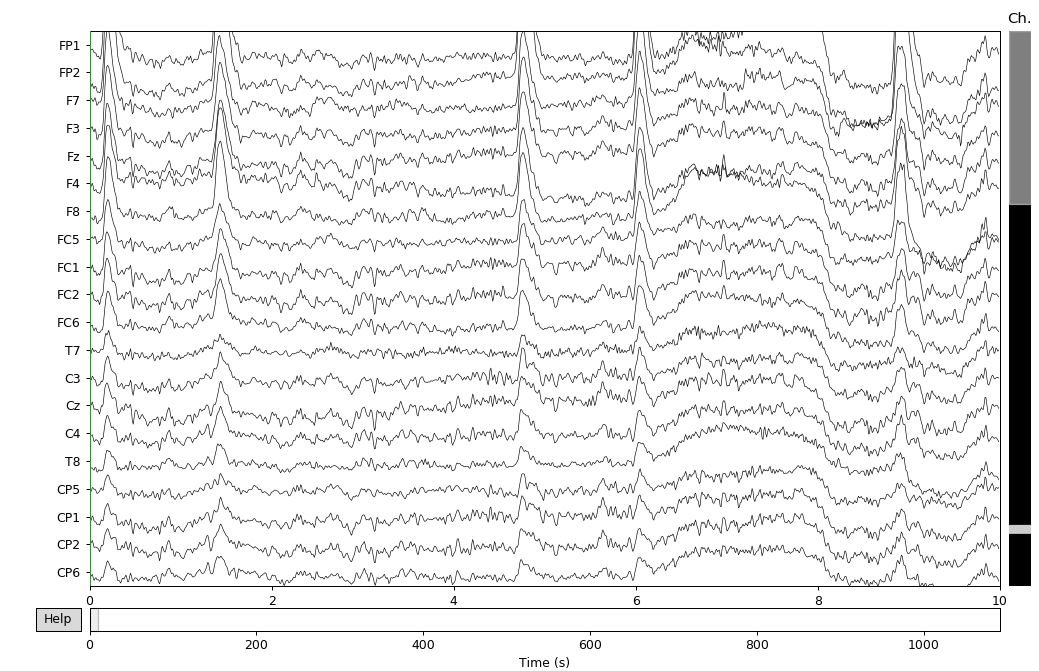

In [26]:
raw.plot();

try applying a filter to our `raw` object

### Filtering

In [5]:
raw.filter(1, 20)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. raw.filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

mne tells us, that it doesn't store raw objects in memory. But it gives us the option to define `preload=True` when reading in raw files 

In [5]:
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file oddball_example_small-fif.gz...


<ipython-input-5-7341ee706cdd>:1: RuntimeWarning: This filename (oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.
Reading 0 ... 109097  =      0.000 ...  1090.970 secs...


now try filtering again...

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 331 samples (3.310 sec)



<IPython.core.display.Javascript object>


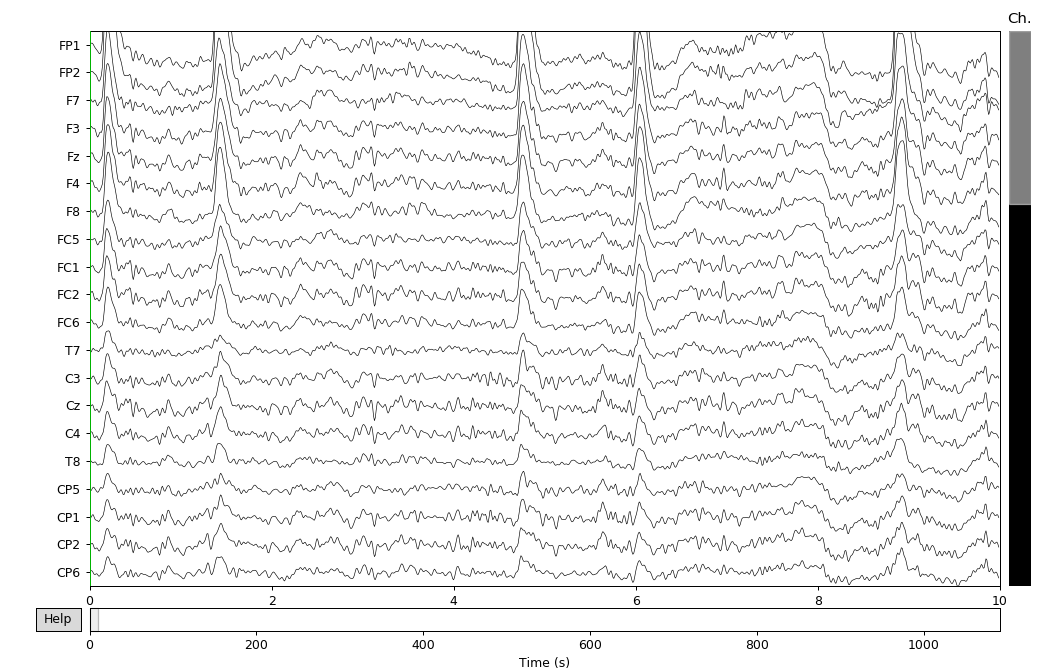

In [28]:
raw.copy().filter(1, 20).plot();

Now we can inspect our raw data again. Do we notice anything?

<IPython.core.display.Javascript object>


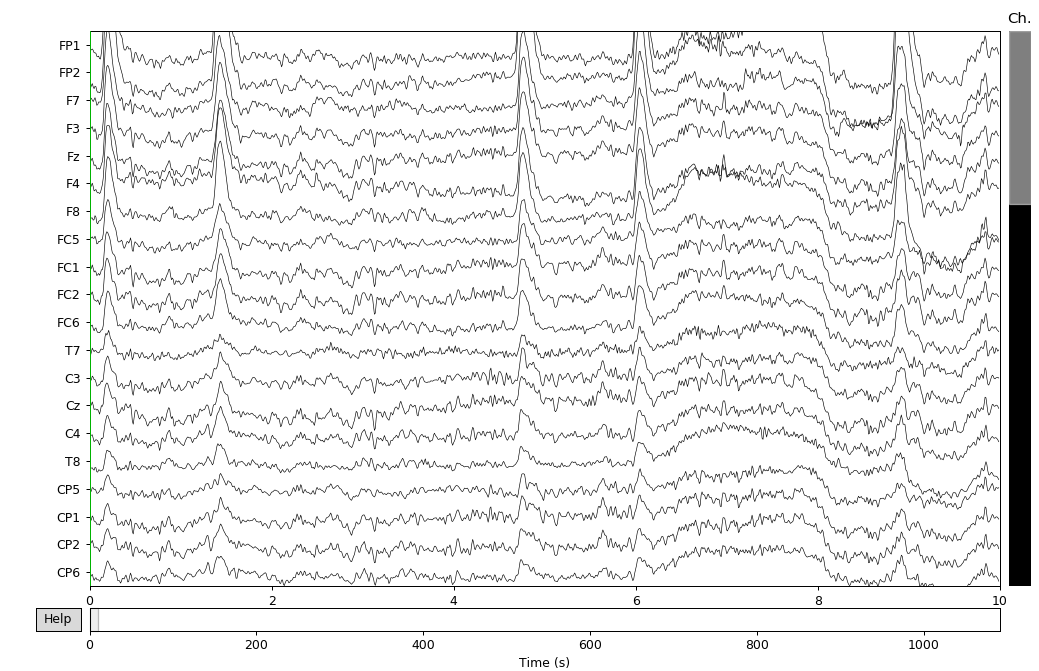

In [16]:
raw.plot();

but we want to actually apply the filter to our raw data, not only the copy:

In [6]:
raw.filter(1, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 331 samples (3.310 sec)



<Raw  |  oddball_example_small-fif.gz, n_channels x n_times : 64 x 109098 (1091.0 sec), ~53.4 MB, data loaded>

## Events & Epochs

For epoching the data, we need event markers. In our case they can be detected in the `raw` object, specifically the stimulus channel.

In [38]:
?mne.find_events

It says, that it defaults to channel `STI 014` if present. How would you find out if that channel name exists for your raw data?

In [ ]:
raw.

In [31]:
events = mne.find_events(raw)

903 events found
Event IDs: [100 200]


`events` is simply an array (time in samples, zero, trigger);

In [32]:
events

array([[  3241,      0,    200],
       [  3437,      0,    200],
       [  3643,      0,    200],
       ...,
       [111496,      0,    200],
       [111613,      0,    200],
       [111719,      0,    200]])

We can also visualize the events

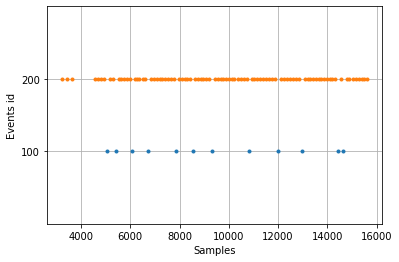

In [33]:
mne.viz.plot_events(events[:100]);

For creating an `mne.Epochs` object, we require, in addition to the `raw` object and the `events` array, a dictionary of the intended condition names and the corresponding trigger numbers, our so called `event_id`

In [34]:
event_ids = {"standard/stimulus": 200, "target/stimulus": 100}

epochs = mne.Epochs(raw, events, event_id=event_ids, preload=True)

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 903 events and 71 original time points ...
0 bad epochs dropped


Aaaaaaand visualize

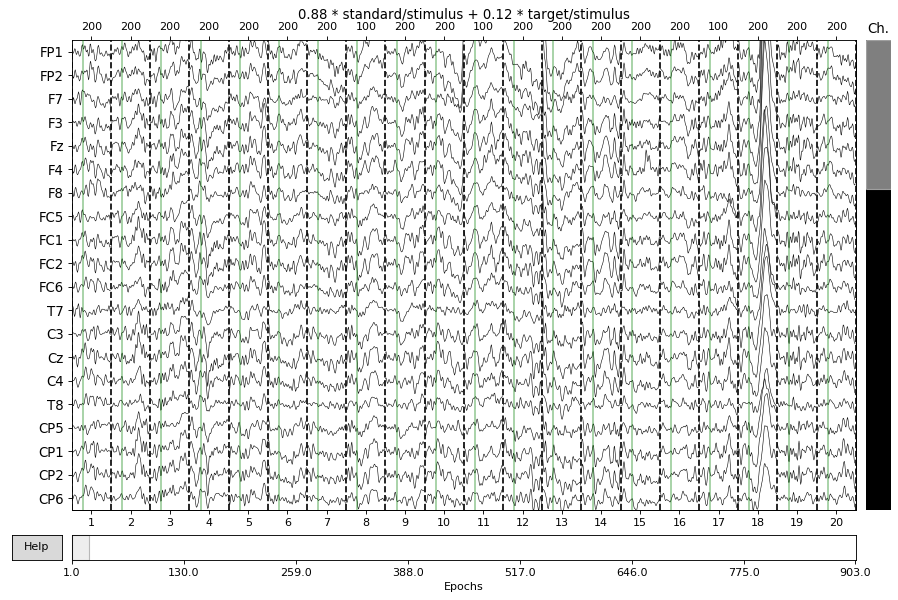

In [35]:
epochs.plot();

Those big spikes are EOG (electrooculogram) artifacts. Electrical noise generated by eye movements. 
We can use a method called ICA to correct for those artifacts. Next session we will give you some more theoretical input of how it works, for now we will just create an ICA object
and use its `.fit` method on a filtered copy of the raw data do demonstrate the effect:

In [36]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw.copy().filter(8, 35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 165 samples (1.650 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 1.6s.


<ICA  |  raw data decomposition, fit (fastica): 109098 samples, 20 components, channels used: "eeg">

We can use an inbuilt algorithm to find components that are correlated to EOGs.

In [37]:
bad_idx, scores = ica.find_bads_eog(raw, 'SO2', threshold=2)
print(bad_idx)

Using channel SO2 as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1024 samples (10.240 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 

In [38]:
epochs = ica.apply(epochs, exclude=bad_idx)

Transforming to ICA space (20 components)
Zeroing out 2 ICA components


Now lets look at our epoched data again:

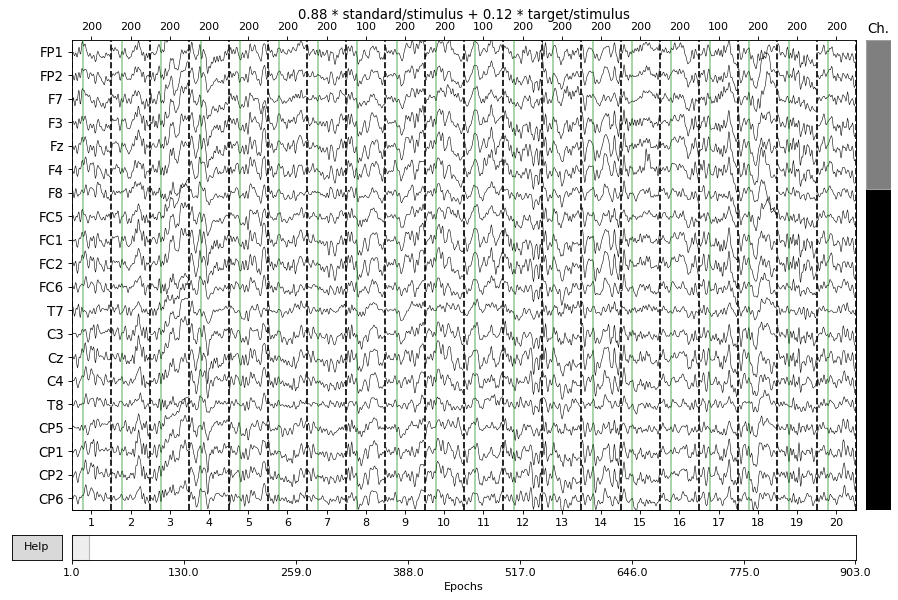

In [39]:
epochs.plot();

We can also index specific events in our `epochs` object.

In [40]:
epochs['standard/stimulus'] == epochs['standard']

True

In [41]:
epochs['target/stimulus'] == epochs['target']

True

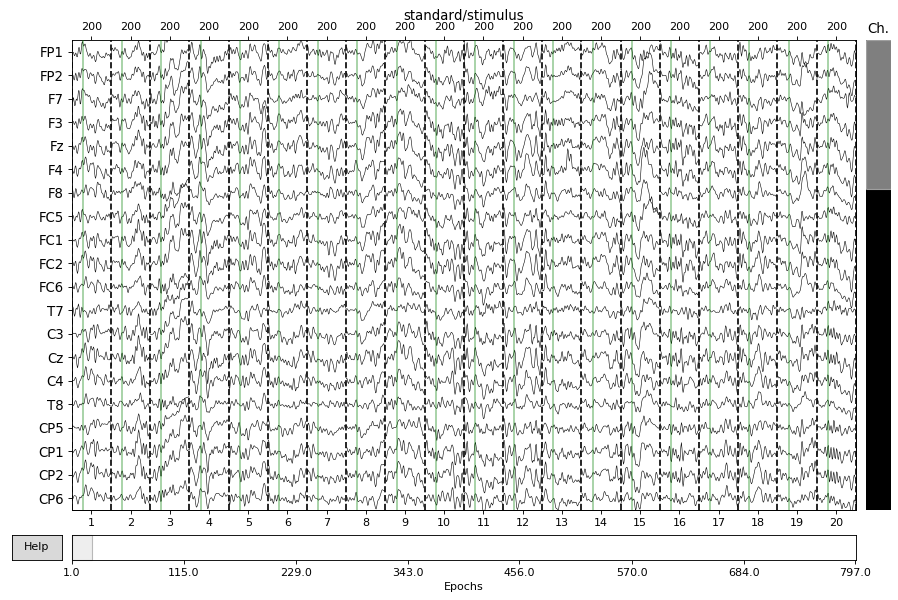

In [42]:
epochs['standard'].plot();

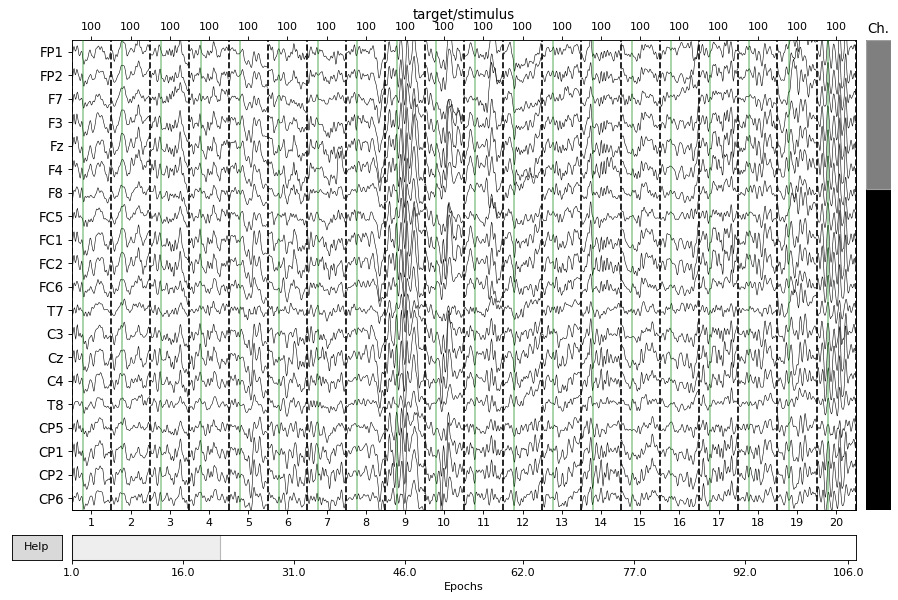

In [43]:
epochs['target'].plot();

In [27]:
%matplotlib inline

Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []


Epochs objects have many methods, including baselining and changing the time window length. 

In [44]:
epochs.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs  |   903 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~31.4 MB, data loaded,
 'standard/stimulus': 797
 'target/stimulus': 106>

In [45]:
epochs.equalize_event_counts(event_ids)
epochs

Dropped 691 epochs


<Epochs  |   212 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~7.5 MB, data loaded,
 'standard/stimulus': 106
 'target/stimulus': 106>

We can also save our epoched data to disk, so that we don't have to redo all the preprocessing the next time.

In [46]:
epochs.save("oddball-epo.fif")  # remember, the data has been cleaned of bad ICs

Overwriting existing file.


<ipython-input-46-94f0ec168e5e>:1: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save("oddball-epo.fif")  # remember, the data has been cleaned of bad ICs


## Evokeds

Evoked objects are averaged epoched data over trials.

In [48]:
target = epochs["target"].average()
standard = epochs["standard"].average()

There are a number of plotting functions for inspecting the evoked object.

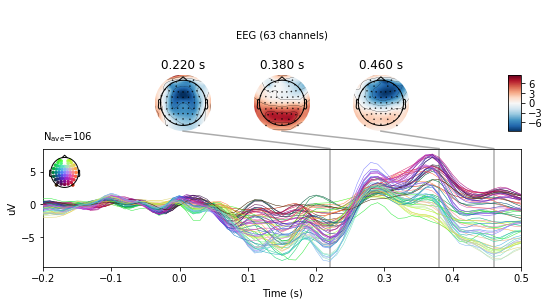

In [59]:
target.plot_joint();

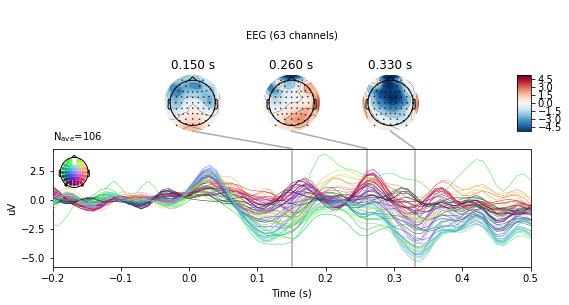

In [50]:
standard.plot_joint();

For inspecting contrasts we can use joint plots:

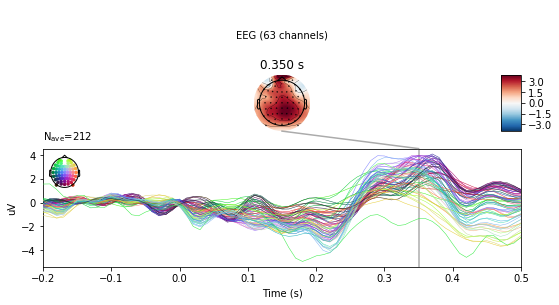

In [62]:
diff = mne.combine_evoked((target, -standard), weights='equal')
diff.plot_joint(times=.35);

To contrast multiple conditions, `mne.viz.plot_compare_evokeds` is available:

No picks, plotting the GFP ...


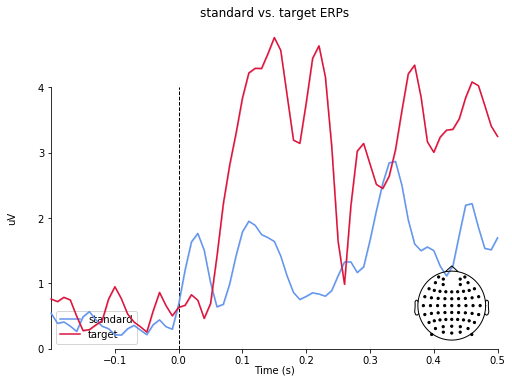

In [46]:
mne.viz.plot_compare_evokeds({"standard": standard,
                              "target": target}, 
                             title="standard vs. target ERPs",
                             show_sensors="lower right", truncate_yaxis="max_ticks");

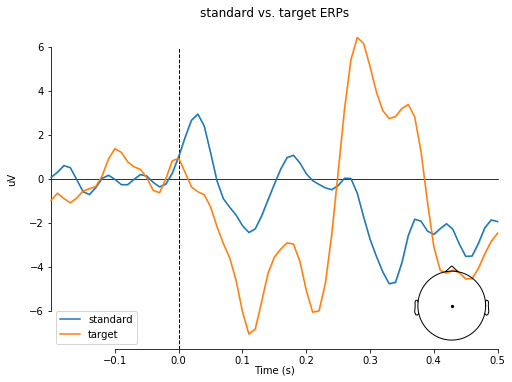

In [48]:
mne.viz.plot_compare_evokeds({"standard": standard,
                              "target": target}, 
                             picks=[13],
                             title="standard vs. target ERPs",
                             show_sensors="lower right", truncate_yaxis="max_ticks");